The process for OTE-01 and OTE-02 will be the same, the difference being that OTE-02 will have PSFs that are not saturated and we will have the precise boresight. Both sets of images are expecting to have high backgrounds.

To do:
- get boresight
- get estimate of segment ID


take the locations of the PSFs in the image:
- get the encircled energy and FWHM for each PSF (use the modified poppy functions and photutils?) - we should be able to get that from Shadow
- find distance to boresight center for each
- cut out each psf and put in a 2048x2048 at the locations in the LOS-02 image
    - what happens if there are some PSFs we don't know which one it is?
    - use jwst_magic.convert_image.convert_image_to_raw_fgs.create_seed_image, create my own all_psfs file?

Goals:
- have a sense of what our large image array will look like
- how much we expect each PSF to change
- ideally run it through MAGIC and try to make it work

In [155]:
import os

from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import from_levels_and_colors
from matplotlib import cm
import numpy as np
import pandas as pd

from jwst_magic import convert_image

%matplotlib inline

In [156]:
# DO NOT CHANGE THESE LOCATIONS
SEGMENTS = ["A1-1", "A2-2", "A3-3", "A4-4", "A5-5", "A6-6", 
            "B1-7","B2-9", "B3-11", "B4-13", "B5-15", "B6-17", 
            "C1-8", "C2-10", "C3-12", "C4-14", "C5-16", "C6-18"]
GA_PSF_LOCATIONS = {'A1-1':[1015, 1210],
                    'A2-2':[856, 1116],
                    'A3-3':[864, 931],
                    'A4-4':[1023, 837],
                    'A5-5':[1180, 936],
                    'A6-6':[1185 , 1126],
                    'B1-7':[1011, 1402],
                    'B2-9':[691, 1208],
                    'B3-11':[686, 822],
                    'B4-13':[1027, 676],
                    'B5-15':[1346, 843],
                    'B6-17':[1335, 1213],
                    'C1-8':[854, 1300],
                    'C2-10':[695, 1019],
                    'C3-12':[866, 742],
                    'C4-14':[1188, 744],
                    'C5-16':[1342, 1033],
                    'C6-18':[1172, 1304]
                    }

In [157]:
def distance_to_boresight(x, y, truth_x, truth_y):
    '''
    calculate the distance from the PSF in OTE-01 to it's location in OTE-06/LOS-02
    truth_x and truth_y are the location of the boresight
    '''
    
    return np.sqrt( (truth_x - x)**2 + (truth_y - y)**2 )


In [158]:
def get_position_from_magic(image):
    # Get x and y postitions of each identifiable PSF in the MOSAIC
    # The identified PSFs might not all be from the target star and some from the target star might be missing
    x_list, y_list, _, _ = convert_image.convert_image_to_raw_fgs.create_all_found_psfs_file(image, 
                                                                                             guider=1, 
                                                                                             root=None, 
                                                                                             out_dir=None, 
                                                                                             smoothing='default', 
                                                                                             save=False)
    return x_list, y_list

In [159]:
def read_shadow_log(filename, params_to_include=['x', 'y', 'fwhm', 'fwhm_x', 'fwhm_y', 'ellipse']):
    """
    From the txt file provided from Shadow, pull out helpful information.
    
    The default is to pull out the x & y locations of each identified PSF, the average FWHM, the FWHM in x and y,
    and the ellipticity.
    """
    labels = ['ra_txt', 'dec_txt', 'equinox', 'x', 'y', 'fwhm', 'fwhm_x', 'fwhm_y', 'starsize', 'ellipse', 
          'background', 'skylevel', 'brightness', 'time_local', 'time_ut', 'ra_deg', 'dec_deg']

    info = pd.read_csv(filename, delimiter=' ', skiprows=[0, 1], names=labels)
    
    info_squeezed = info[params_to_include].copy()
    return info_squeezed

In [160]:
def plot_mosaic_with_psfs(mosaic, car, x_list=None, y_list=None, est_target_location=None, xlim=None, ylim=None):
    """
    Plot out the mosaic image with the identified PSFs and estimated target location plotted
    """
    plt.figure(figsize=(14, 14))
    
    plt.imshow(mosaic, norm=LogNorm(), origin='lower')
    if not None in [x_list, y_list, est_target_location]:
        plt.scatter(est_target_location[0], est_target_location[1], s=500, marker='*', c='white', edgecolor='C1', 
                    label='Estimated Target Location')
        for j, (x, y) in enumerate(zip(x_list, y_list)):
            plt.annotate(j, (x, y), (x-15, y-20), c='black')

        if xlim is not None:
            plt.xlim(xlim)
        if ylim is not None:
            plt.ylim(ylim)
        plt.legend()
    
    plt.title(f"{car} Mosaic")
    plt.show()
    
    
def plot_each_identified_segment_psf(image, car, x_list, y_list, window_size=40):
    """
    Cut each segment out of the mosaic/image provided based on the x and y locations given with x_list, and y_list
    """
    radius = window_size//2
        
    img_per_row = 3
    rows = len(x_list)//img_per_row+1
    columns = len(x_list) if len(x_list)<img_per_row else img_per_row
    fig, ax = plt.subplots(rows, columns, figsize=(6*columns, 6*rows))

    i = 0
    for j in range(rows):
        for k in range(columns):
            try:
                cutout = image[int(y_list[i])-radius:int(y_list[i])+radius, int(x_list[i])-radius:int(x_list[i])+radius]
                ax[j, k].imshow(cutout, origin='lower')
                ax[j, k].set_title(f'PSF {i}')
                i+=1
            except IndexError:
                ax[j, k].axis('off')
                break
    plt.show()
    

In [161]:
def match_psf_params_to_segment(info_df, matching_dictionary, target_location):
    """
    Match the location and other PSF parameters to the segment based on the matching dictionary. Also calculate 
    the distance from each segment to the boresight
    """
    truth_x, truth_y = target_location
    seg_location_dictionary = {matching_dictionary[ind] : {'location': (int(info_df['x'].values[ind]), 
                                                                    int(info_df['y'].values[ind])),
                                                       'fwhm': info_df['fwhm'].values[ind],
                                                       'fwhm_x': info_df['fwhm_x'].values[ind],
                                                       'fwhm_y': info_df['fwhm_y'].values[ind],
                                                       'ellipticity': info_df['ellipse'].values[ind],
                                                       'distance_to_target': distance_to_boresight(info_df['x'].values[ind],
                                                                                                   info_df['y'].values[ind], 
                                                                                                   truth_x, 
                                                                                                   truth_y)
                                                       } for ind in matching_dictionary.keys()}
    return seg_location_dictionary


In [162]:
def get_values(seg_location_dictionary, parameter, decimals=2):
    """
    Get the PSF parameters from the dictionary
    """
    values = []
    for key in seg_location_dictionary:
        values.append(np.round(seg_location_dictionary[key][parameter], decimals))
    return values 

def grab_vmin_vmax(param):
    """ Give a vmin & vmax depending on what parameter we are plotting
    """
    if 'fwhm' in param:
        vmin = 10 # TBD
        vmax = 20 # TBD
        cmap = cm.RdYlGn_r
    elif param == 'ellipse':
        vmin = 0
        vmax = 1
        cmap = cm.RdYlGn
    else:
        vmin = None
        vmax = None
        cmap = cm.RdYlGn_r

    return vmin, vmax, cmap

        
def plot_parameters(xs, ys, values, title, cmap=cm.RdYlGn_r):
    """
    Plot the PSF parameters 
    """
    center_x = np.median(xs)
    center_y = np.median(ys)
    
    # plot out new image with distance color coded by how far from boresight
    fig = plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.scatter(xs, ys, marker='o', s=100, c=values, cmap=cmap)
    plt.colorbar()
    plt.ylim(center_y+1024, center_y-1024)
    plt.xlim(center_x-1024, center_x+1024)
    plt.show()
    
def plot_multiple_parameters(parameters, info_dictionary, xs=None, ys=None):
    fig, ax = plt.subplots(1, len(parameters), figsize=(6*len(parameters), 8))
    segs = info_dictionary.keys()
    if xs is None and ys is None:
            xs = get_values(info_dictionary, 'x')
            ys = get_values(info_dictionary, 'y')
    for i, (seg, param) in enumerate(zip(segs, parameters)):
        values = get_values(info_dictionary, param)
        for j, (x, y) in enumerate(zip(xs, ys)):
            ax[i].annotate(j, (x, y), (x+15, y+15))
        vmin, vmax, cmap = grab_vmin_vmax(param)
        pl = ax[i].scatter(xs, ys, marker='o', s=100, c=values, cmap=cmap, vmin=vmin, vmax=vmax)
        fig.colorbar(pl, ax=ax[i], orientation='horizontal')
        ax[i].set_title(param)
    

# Table of Contents
1. [After OTE-01](#After-OTE-01)
2. [After OTE-02](#After-OTE-02)
3. [After OTE-03](#After-OTE-03)
4. [After OTE-04](#After-OTE-04)
5. [After OTE-05](#After-OTE-05)
6. [After OTE-06](#After-OTE-06)

# After OTE 01 

(From Marcio)

The goal of OTE-01 is to find the 18 segments. 

There will be a range of focus for the PSFs, some will be close to focus, some will be out of focus. This will create a bunch of saturated PSF because by requirement the target star should be very bright and isolated. If a PSF is not saturated, it likely has a large defocus. The closer to focus, more saturation is expected. After finding the segments we define an initial offset given by a rough estimate of the center of the PMSA deployment. We can inspect the shape of the PSFs by looking at the fainter background stars. Therefore, you should be able to have some idea of the shape of the PSF but without any segment identification. 

**Note that we use  downsampled images for the mosaic** but we do have the normal DMS images, so Shadow can give you the name of the DMS file that has the segments that you need for your testing (not downsampled).

### What you will expect to have from WSS Shadow
1. Path to the mosaic
2. Txt file that includes: 
    - ra_txt: RA in HH:MM:SS
    - dec_txt: Dec in HH:MM:SS
    - equinox: 
    - x: X location of the PSF in the mosaic image
    - y: Y location of the PSF in the mosaic image
    - fwhm: The average FWHM of the PSF
    - fwhm_x: FWHM of the PSF in the X direction
    - fwhm_y: FWHM of the PSF in the Y direction
    - starsize: The average FWHM in arcseconds
    - ellipse: 0 - 1 where 0 is more elliptical, and 1 is more circular
    - background: 
    - skylevel: 
    - brightness: 
    - time_local: Local time of observation
    - time_ut: UTC time of observation 
    - ra_deg: RA in degrees
    - dec_deg: Dec in degrees
3. A general idea of the location of the target star in the mosaic image

In [163]:
# CAR information
car = 'OTE-01'
program_id = 1134

In [164]:
#########################################################
#### CELL TO EDIT - Get all of these from WSS Shadow ####
#########################################################

main_directory = '/ifs/jwst/tel/TeamPractices/'

sw_mosaic = os.path.join(main_directory, f'{car}/mosaic0_obs1-2_median_sub_gbrady_05032021.fits')#'OTE-01/Ball_Deployment-2/WARM/output/mosaic0_quip.fits')

# Location of the file exported from QUIP
info_from_shadow = '/Users/kbrooks/Desktop/pick_log.txt'

# Define location of the target in the image
target_location = None #(4000, 6000)

In [165]:
# Open image
image_ote01 = fits.getdata(sw_mosaic)

# Correct negative pixels
image_ote01[image_ote01<=0] = 3e-20

# Load file
info_df = read_shadow_log(info_from_shadow)

In [166]:
info_df

,x,y,fwhm,fwhm_x,fwhm_y,ellipse
0,3183.122917,6682.173009,17.486145,7.064045,23.698730,0.298077
1,3734.581458,6548.935658,8.621786,9.454321,7.699754,0.814416
2,3699.249464,6281.197796,14.495469,13.376130,15.534361,0.861067
3,4008.829903,6889.956856,12.208638,15.344006,7.916006,0.515902
4,4598.353512,6856.156425,12.127656,14.670776,8.884167,0.605569
5,4846.137409,6160.521621,13.314526,13.602824,13.019846,0.957143
6,4173.948920,5768.065227,20.724278,24.147565,16.609832,0.687847
7,4183.948593,5631.367309,12.303161,6.628720,16.087126,0.412051
8,4462.618462,6234.218139,21.980427,20.928984,22.983820,0.910596
9,4430.374239,6149.924094,23.889754,23.315321,24.450695,0.953565


In [167]:
# Set target location by averaging the PSF positions if not given by shadow
if target_location is None:
    target_x = np.median(info_df['x'].values)
    target_y = np.median(info_df['y'].values)
    target_location = (int(target_x), int(target_y))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

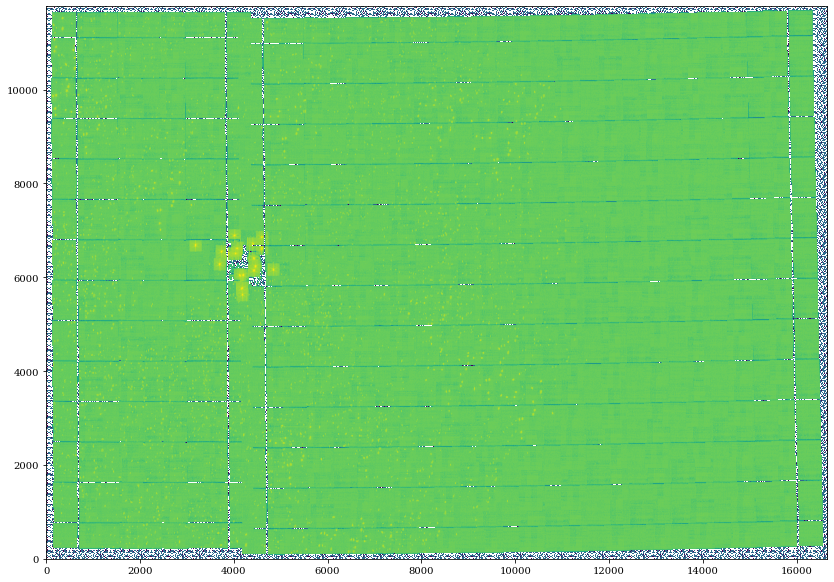

In [168]:
# Plot the full mosaic with the estimated target location and identified PSFs
plot_mosaic_with_psfs(image_ote01, car, info_df['x'].values, info_df['y'].values, 
                      target_location, xlim=None, ylim=None)

In [ ]:
Slack shadow person

In [ ]:
###########################################################################################
# CELL TO EDIT - UPDATE THE XLIM AND YLIM VALUES TO ZOOM IN ON THE SET OF PSFS OF INTEREST #
###########################################################################################
xlim = (2500, 5500)
ylim = (5000, 7500)


# Zoom in on the identified PSFs
plot_mosaic_with_psfs(image_ote01, car, info_df['x'].values, info_df['y'].values, 
                      target_location, xlim=xlim, ylim=ylim)

In [ ]:
# Cut out each segment and do a visual check
plot_each_identified_segment_psf(image_ote01, car, info_df['x'].values, info_df['y'].values, window_size=40)

## Look at values provided by Shadow 

In [ ]:
# Make a PSF location dictionary
info_dictionary = info_df.to_dict(orient='index')

### First look at FWHM and Ellipticity 

In [ ]:
plot_multiple_parameters(['fwhm', 'ellipse', 'distance'], info_dictionary)

In [ ]:
# TODO: look at distance from "center"
# The distance to the estimated target location will give an indication of how much the segment might change once 
# it has been put in it's Large Array location in OTE-06

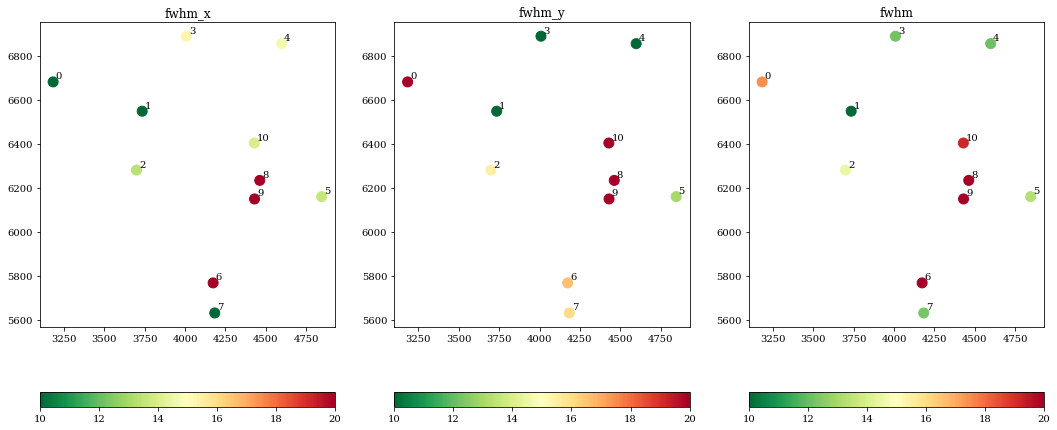

In [92]:
# Look at FWHM x and y (though the images should tell you the same information)
plot_multiple_parameters(['fwhm_x', 'fwhm_y', 'fwhm'], info_dictionary)

Tally up how many of the above PSFs that are in the green for both FWHM and ellipse: 5 

In [134]:
# Indices of the better PSFs: 
# Change these values as needed
fwhm_limit = 15
ellipse_limit = 0.4 #TODO: Figure out if 0 or 1 is more circular - this is completely not clear from these PSFs

good_inds = []
for key in info_dictionary.keys():
    if info_dictionary[key]['fwhm'] < fwhm_limit and info_dictionary[key]['ellipse'] > ellipse_limit:
        good_inds.append(key)


In [135]:
good_inds

[1, 2, 3, 4, 5, 7]

If the number of "Good" PSFs is more than 6, then we can feel confident that we can get a guiding scenario. If it is less than 6, then we will need OTE-03

In [136]:
if len(good_inds) < 7:
    print(f'We only have {len(good_inds)} PSFs that we think are good enough for guiding. We need more than 6.')
else:
    print(f'We have {len(good_inds)} PSFs that we think are good enough for guiding, which is enough.')

We only have 6 PSFs that we think are good enough for guiding. We need more than 6.


# After OTE 02

(From Marcio)

We use the OTE-01 initial mosaic offset from the expected target and do our first telescope correction, so it points roughy to the center of the initial deployment. Shadow creates a new mosaic with the "correct" WCS. For OTE-02 we have NIRCam A and ALL images, so we should have a partial view of the initial deployment (not mosaic) but these should have no saturated PSF (or at least some, because it could be difficult to have non-saturated PSF if the defocus is too large between all segments). At this point, we can have the same information as in OTE-01 but with a better PSF quality/exposure than before, for most PSFs.

*Do the same analysis that you did after OTE-01, just with the image of the partial deployment*

In [139]:
# CAR information
car = 'OTE-02'
program_id = 1135

In [140]:
#########################################################
#### CELL TO EDIT - Get all of these from WSS Shadow ####
#########################################################

partial_view_of_deployment = os.path.join(main_directory, f'{car}/output/mosaic0_OTE-02-Obs1+2-SW.fits')

# Location of the file exported from QUIP
info_from_shadow = ''

# Define location of the target in the image
target_location = None

In [141]:
# Open image
image_ote02 = fits.getdata(partial_view_of_deployment)

# Correct negative pixels
image_ote02[image_ote02<=0] = 3e-20

# Load file
if info_from_shadow:
    info_df = read_shadow_log(info_from_shadow)
    info_df
else:
    info_df = None

In [29]:
# Set target location by averaging the PSF positions if not given by shadow
if target_location is None and info_from_shadow:
    target_x = np.median(info_df['x'].values)
    target_y = np.median(info_df['y'].values)
    target_location = (int(target_x), int(target_y))

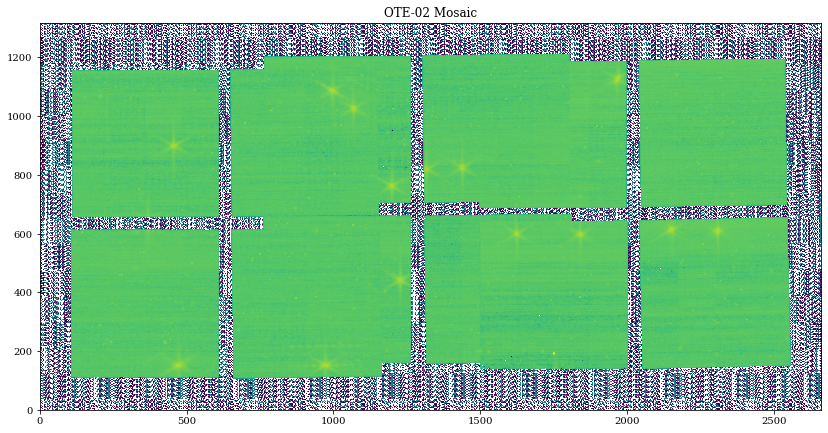

In [147]:
# Plot the full mosaic with the estimated target location and identified PSFs
plot_mosaic_with_psfs(image_ote02, car, None, None, 
                      target_location, xlim=None, ylim=None)

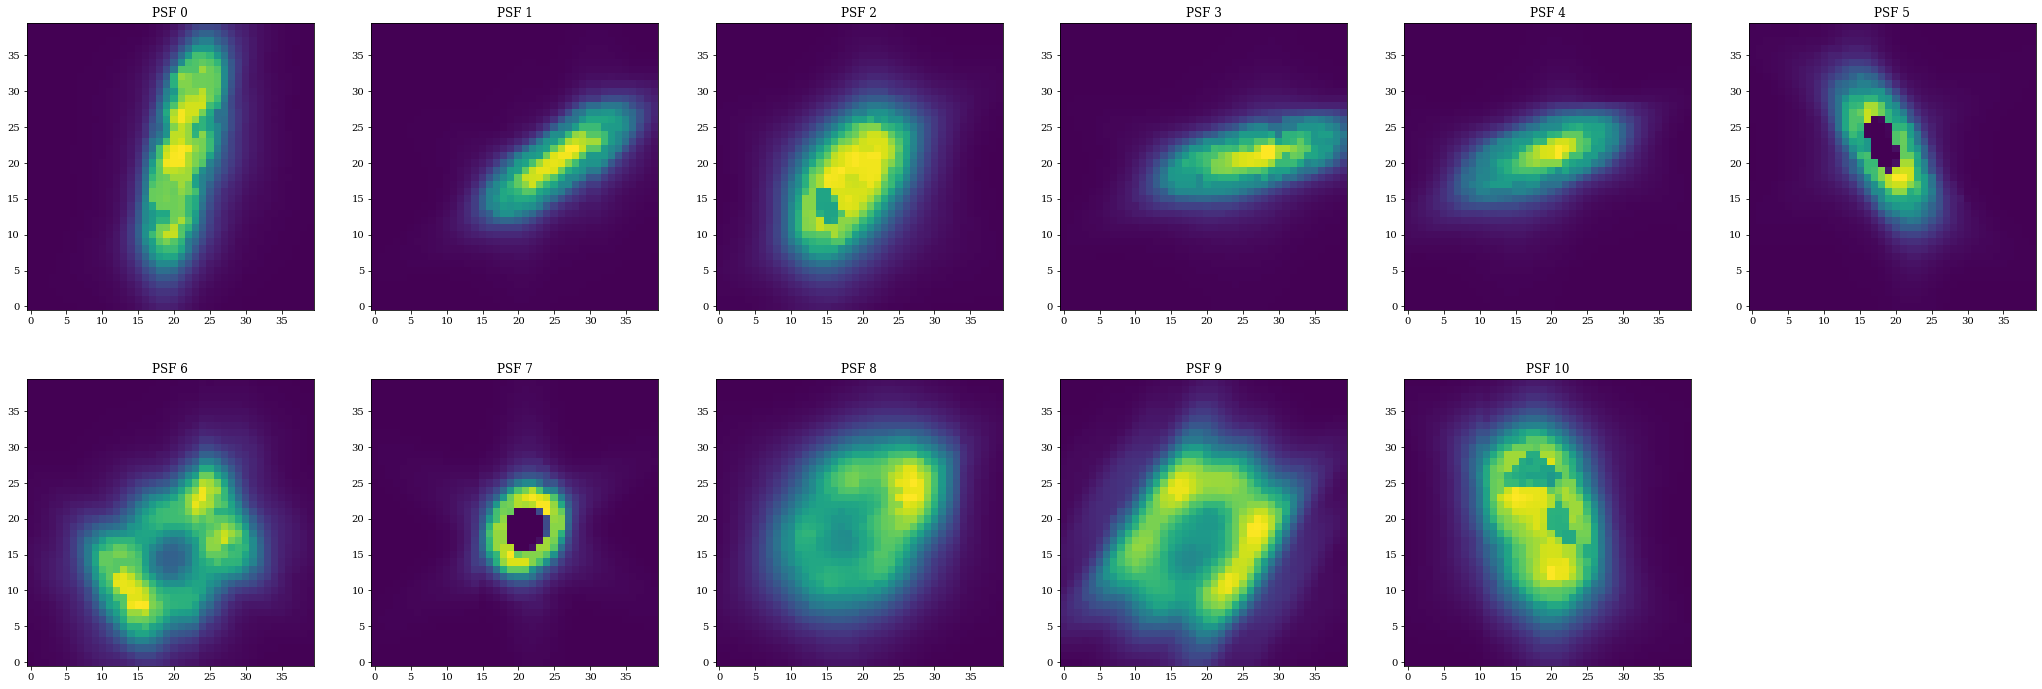

In [128]:
# Cut out each segment and do a visual check
plot_each_identified_segment_psf(image_ote02, car, info_df['x'].values, info_df['y'].values, window_size=40)

## Look at values provided by Shadow 

In [39]:
# Make a PSF location dictionary
info_dictionary = info_df.to_dict(orient='index')

### First look at FWHM and Ellipticity 

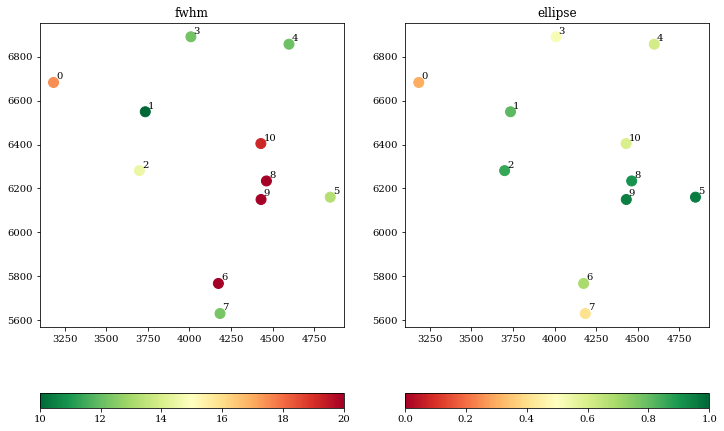

In [91]:
plot_multiple_parameters(['fwhm', 'ellipse'], info_dictionary)

Tally up how many of the above PSFs that are in the green for both FWHM and ellipse: 5 

In [134]:
# Indices of the better PSFs: 
# Change these values as needed
fwhm_limit = 15
ellipse_limit = 0.4 #TODO: Figure out if 0 or 1 is more circular - this is completely not clear from these PSFs

good_inds = []
for key in info_dictionary.keys():
    if info_dictionary[key]['fwhm'] < fwhm_limit and info_dictionary[key]['ellipse'] > ellipse_limit:
        good_inds.append(key)


In [135]:
good_inds

[1, 2, 3, 4, 5, 7]

If the number of "Good" PSFs is more than 6, then we can feel confident that we can get a guiding scenario. If it is less than 6, then we will need OTE-03

In [136]:
if len(good_inds) < 7:
    print(f'We only have {len(good_inds)} PSFs that we think are good enough for guiding. We need more than 6.')
else:
    print(f'We have {len(good_inds)} PSFs that we think are good enough for guiding, which is enough.')

We only have 6 PSFs that we think are good enough for guiding. We need more than 6.


# After OTE 03

(From Marcio)

**0TE-03 is optional, but likely to occur.** 

Again, this is not a mosaic, so we only get the PSF inside the NIRCam ALL exposure. This is the first time that we will have some predicted segment identification. At the end of OTE-03 we should have a tentative segment ID and better (or more compact) PSFs for guiding.

In [ ]:
# CAR information
car = 'OTE-03'
program_id = 1136

In [140]:
#########################################################
#### CELL TO EDIT - Get all of these from WSS Shadow ####
#########################################################

partial_view_of_deployment = os.path.join(main_directory, f'{car}/output/mosaic0_OTE-02-Obs1+2-SW.fits')

# Location of the file exported from QUIP
info_from_shadow = ''

# Define location of the target in the image
target_location = None

Now, we have a better idea of which segment is which, AND we have focus diversity. Here we will match the PSF in the images we have with their segment name, and then cut that out of the images that we have and put at their GA positions. This prepares us for OTE-07

In [ ]:
# These images are not down sampled, correct?
# Images at new SM location


# Images with SM at -400um


# Images with SM at +400um


In [192]:
#### CELL TO EDIT
# With the help of Shadow, determine which of the labelled PSFs are associated with a segment
# In the dictionary below, put the number from above BEFORE the ":" for each segment where Shadow thinks we have a
#  match. Delete any entries where the segment is unknown
matching_dictionary = { 1  :'A1-1', 
                        3  :'A2-2', 
                        6  :'A3-3', 
                        0  :'A4-4', 
                        7  :'A5-5', 
                        10 :'A6-6', 
                        4  :'B1-7',
                        5  :'B2-9', 
                        9  :'B3-11', 
                        8  :'B4-13', 
                        2  :'B5-15'#, 
#                         :'B6-17', 
#                         :'C1-8', 
#                         :'C2-10', 
#                         :'C3-12', 
#                         :'C4-14', 
#                         :'C5-16', 
#                         :'C6-18'
                      } 


In [283]:
# Match the location to the segment based on the matching dictionary

seg_location_dictionary = match_psf_params_to_segment(info_df, matching_dictionary, target_location)

In [292]:
# Put known segment postage stamps in large image array locations
box = 60
large_image_array = np.zeros([2048, 2048])

xs = []
ys = []
for seg in seg_location_dictionary.keys():
    mosaic_x, mosaic_y = seg_location_dictionary[seg]['location']
    psf = image[mosaic_y-box:mosaic_y+box, mosaic_x-box:mosaic_x+box]
    ga_x, ga_y = GA_PSF_LOCATIONS[seg]
    xs.append(ga_x)
    ys.append(ga_y)
    large_image_array[ga_y-box: ga_y+box, ga_x-box:ga_x+box] = psf

large_image_array[large_image_array<=0] = 3e-20

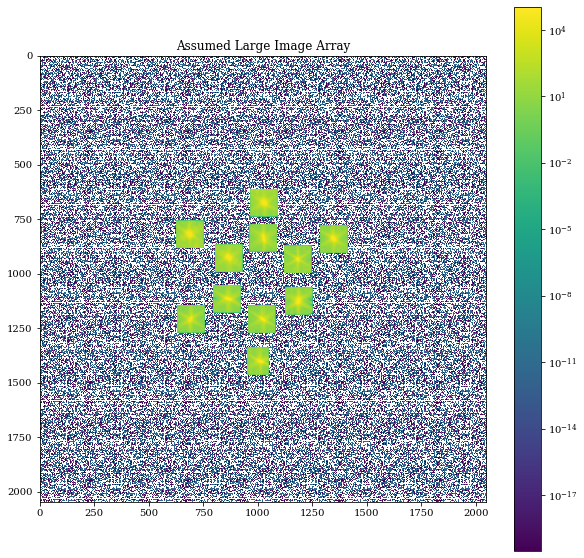

In [293]:
# plot out new image with distance color coded by how far from boresight
plt.figure(figsize=(10, 10))
plt.imshow(large_image_array, norm=LogNorm())
plt.title(f"Assumed Large Image Array")
plt.colorbar()
plt.show()

### Plot heat map of distances from estimated target location 

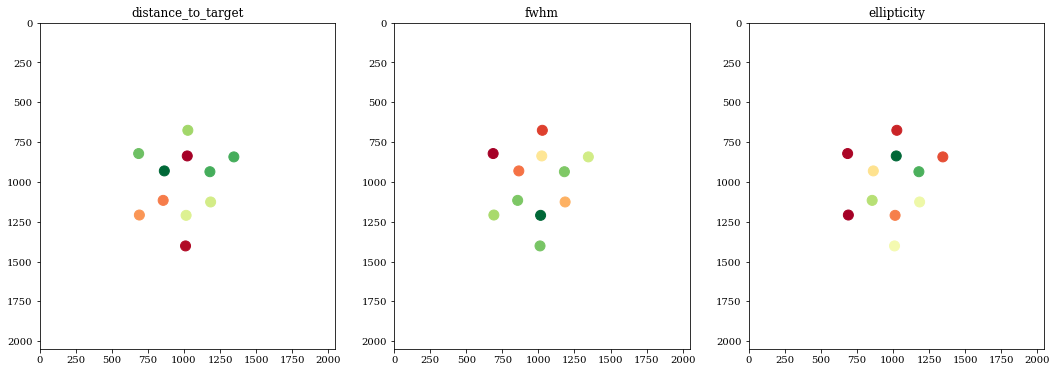

In [287]:
# Look at high level numbers
plot_multiple_parameters(['distance_to_target', 'fwhm', 'ellipticity'], seg_location_dictionary, xs, ys)

In [149]:
# Break down the FWHM further
plot_multiple_parameters(['fwhm', 'fwhm_x', 'fwhm_y'], seg_location_dictionary, xs, ys)

NameError: name 'seg_location_dictionary' is not defined

# After OTE 04

(From Marcio)

We'll have different NIRCam ALL exposures to capture all segments. At the end of OTE-04 we should have the ID of each segment, with images of all the segments. This could be a good time to do a full PSF characterization. Shadow can help. The "only" caveat is that some segments may be on top or close to each other, thus, some contamination could affect the PSF measurements.

In [1]:
# CAR information
car = 'OTE-04'
program_id = 1137

**Guiding Goal**: Make the segment image array with the segments we have and test through MAGIC+DHAS

# After OTE 05

(From Marcio)

Another matrix update. I think similar to OTE-02 but in this case it is because of changes in the SM position after OTE-03. 

In [2]:
# CAR information
car = 'OTE-05'
program_id = 1138

# After OTE 06

(From Marcio)

We form the large array in NIRCam A3. At the end of OTE-06 we'll have the same configuration and PSF as in LOS-02 and the first exposure of OTE-07. This is also a good time to do a full PSF characterization in preparation for Guiding. In fact, it may be the only important place to do it (maybe). In any case, Shadow can help with the assessment.

In [3]:
# CAR information
car = 'OTE-06'
program_id = 1140

# Get simulated NIRCam locations of LOS-02 PSFs 

In [8]:
los02_image = fits.getdata('/ifs/jwst/tel/LRE5/LOS-02/output/LRE5-RfR/jw01410002001_02101_00001_nrca3_cal.fits')

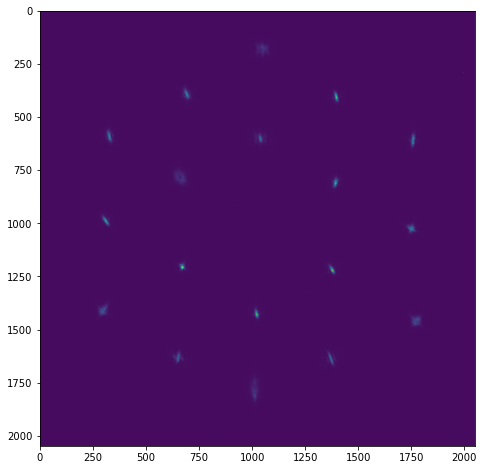

In [9]:
plt.figure(figsize=(10, 8))
plt.imshow(los02_image)

In [10]:
# mapping of magic segment labels to WSS numbers

# Do not change this cell

# MAGIC segment labels to segment naming map
SEGMENT_MAP_G1 = {"A":"B4-13", "B":"C4-14", "C":"C3-12", "D":"B5-15",
                  "E":"A4-4", "F":"B3-11", "G":"A5-5", "H":"A3-3", 
                  "I":"C5-16", "J":"C2-10", "K":"A6-6", "L":"A2-2", 
                  "M":"B6-17", "N":"A1-1", "O":"B2-9", "P":"C6-18", 
                  "Q":"C1-8", "R":"B1-7"}


SEGMENTS = ["A1-1", "A2-2", "A3-3", "A4-4", "A5-5", "A6-6", 
            "B1-7","B2-9", "B3-11", "B4-13", "B5-15", "B6-17", 
            "C1-8", "C2-10", "C3-12", "C4-14", "C5-16", "C6-18"]

In [16]:
guider = 1
segment_map = [SEGMENT_MAP_G1 if guider==1 else SEGMENT_MAP_G2][0]

In [18]:
# Make table
out_dir = '/Users/kbrooks/git_repos/jwst-magic-fork/out/'# +car+out/
root = 'test_los02'
all_psfs_filename = os.path.join(out_dir, root, 
                                 f'unshifted_all_found_psfs_{root}_G{guider}.txt')
all_psfs_table = pd.read_csv(all_psfs_filename, comment='#', 
                             names=['label', f'y', f'x', 
                                    f'countrate'], sep=' ')
segments = [segment_map[label] for label in all_psfs_table['label']]

# Add the segment name to the table
all_psfs_table.insert(1, 'segment', segments)
all_psfs_table = all_psfs_table.sort_values('segment', ascending=True)

In [23]:
all_psfs_locations = all_psfs_table[['segment', 'y','x']]

all_psfs_locations

,segment,y,x
8,A1-1,1015.0,1210.0
4,A2-2,856.0,1116.0
5,A3-3,864.0,931.0
9,A4-4,1023.0,837.0
12,A5-5,1180.0,936.0
13,A6-6,1185.0,1126.0
7,B1-7,1011.0,1402.0
1,B2-9,691.0,1208.0
0,B3-11,686.0,822.0
10,B4-13,1027.0,676.0


In [27]:
truth_locations = all_psfs_locations.set_index('segment').T.to_dict('list')
truth_locations

{'A1-1': [1015.0, 1210.0],
 'A2-2': [856.0, 1116.0],
 'A3-3': [864.0, 931.0],
 'A4-4': [1023.0, 837.0],
 'A5-5': [1180.0, 936.0],
 'A6-6': [1185.0, 1126.0],
 'B1-7': [1011.0, 1402.0],
 'B2-9': [691.0, 1208.0],
 'B3-11': [686.0, 822.0],
 'B4-13': [1027.0, 676.0],
 'B5-15': [1346.0, 843.0],
 'B6-17': [1335.0, 1213.0],
 'C1-8': [854.0, 1300.0],
 'C2-10': [695.0, 1019.0],
 'C3-12': [866.0, 742.0],
 'C4-14': [1188.0, 744.0],
 'C5-16': [1342.0, 1033.0],
 'C6-18': [1172.0, 1304.0]}

In [30]:
truth_locations == ga_psf_locations

True